<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/3_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will introduce some pre-processing steps common in chemometric pipelines.  

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: May 9, 2024

---

<img src="https://pychemauth.readthedocs.io/en/latest/_images/pipeline.png" height=425 align="right"/>

So far we have introduced the concept of a pipeline, which is essentially a combination of:

1. pre-processing steps, ending in a
2. modeling step.

The PyChemAuth [preprocessing subpackage](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth-preprocessing-package) contains a number of different pre-processing steps useful in chemometric applications.The classes discussed below can all be placed in a pipeline as pre-processors like this:
```python
pipe = Pipeline(steps=[
    ('preprocessor_1', PCA_IA(n_components=3)),
    ('preprocessor_2', CorrectedScaler(pareto=True)),
    ('preprocessor_3', SNV(robust=True)),
    ...,
    ('final_model', PLSDA(...))
])

pipe.fit(X_train, y_train)
```

---

In [ ]:
%pip install git+https://github.com/mahynski/pychemauth@main

In [1]:
import sklearn
import imblearn
import pychemauth
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import watermark
%load_ext watermark
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

watermark : 2.4.3
matplotlib: 3.7.2
pychemauth: 0.0.0b4
pandas    : 1.5.3
imblearn  : 0.11.0
numpy     : 1.24.3
sklearn   : 1.3.0



# Scaling and Centering

In many instances, features of the data being used for modeling are recorded in different units, or have very different scales 📏.  As a result, feature scaling is very important pre-processing step in machine learning pipelines.  Here is a nice set of [examples from sklearn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) on how this can impact your models. The same holds true of chemometric applications. Consider the classic wine 🍷 dataset available from sklearn.



In [2]:
from sklearn.datasets import load_wine
data = load_wine(as_frame=True,)

# print(data['DESCR'])
X = data['data']

In [3]:
X

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [4]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


The term "autoscaling" refers to the subtraction of a column's mean and division by its sample standard deviation.

$$
X_{\rm auto} = \frac{X - \bar{X}}{s_X}
$$

This puts all features on the same length scale and centers the distribution around 0.  Models involving PCA often require the matrix to be centered (if not scaled), and in fact, in sklearn this is done [automatically](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

In [5]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler(with_mean=True, with_std=True)
X_auto = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [6]:
# mean is 0 and std is 1 now
X_auto.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [9]:
test = (X['alcohol'] - X['alcohol'].mean()) / X['alcohol'].std(ddof=0)
test.describe()

,alcohol
count,1.780000e+02
mean,-8.382808e-16
std,1.002821e+00
min,-2.434235e+00
25%,-7.882448e-01
50%,6.099988e-02
75%,8.361286e-01
max,2.259772e+00


However, this sort of scaling can be strongly influenced by outliers, so a more robust 💪 method is to use the median and interquartile range instead.

$$
X_{\rm rob} = \frac{X - {\rm med}(X)}{{\rm iqr}(X)}
$$

sklearn has a nice [example](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) comparing the effect of different scalers on data with outliers present.  

A rule of thumb 👍: It is often best to assume there are some outliers present at first and use robust methods during the initial analysis or cleaning of your data.  Once any outliers have been removed, or there is evidence that there are none, it is generally best to go back to using non-robust methods for subsequent analysis.  


In [10]:
from sklearn.preprocessing import RobustScaler

s = RobustScaler(with_centering=True, with_scaling=True)
X_rob = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [11]:
# median is now at 0
X_rob.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,1.780000e+02,178.000000,178.000000,178.000000,178.000000,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000
mean,-0.037553,3.184786e-01,0.018754,-0.001176,0.091662,-0.056631,-6.331158e-02,0.130471,5.128411e-02,1.235201e-01,-0.022372,-0.136564,0.151482
std,0.617359,7.548284e-01,0.789479,0.776643,0.751710,0.591821,5.981190e-01,0.743005,8.176555e-01,7.779483e-01,0.677249,0.576057,0.649964
min,-1.536122,-7.601351e-01,-2.877698,-2.069767,-1.473684,-1.300236,-1.074850e+00,-1.253731,-1.635714e+00,-1.144295e+00,-1.437037,-1.225152,-0.816305
25%,-0.522814,-1.773649e-01,-0.431655,-0.534884,-0.526316,-0.579196,-5.568862e-01,-0.417910,-4.357143e-01,-4.932886e-01,-0.540741,-0.683570,-0.357069
50%,0.000000,-7.502679e-17,0.000000,0.000000,0.000000,0.000000,1.327063e-16,0.000000,-1.587272e-16,1.491862e-16,0.000000,0.000000,0.000000
75%,0.477186,8.226351e-01,0.568345,0.465116,0.473684,0.420804,4.431138e-01,0.582090,5.642857e-01,5.067114e-01,0.459259,0.316430,0.642931
max,1.353612,2.658784e+00,2.503597,2.441860,3.368421,1.442080,1.763473e+00,1.910448,2.892857e+00,2.788591e+00,2.207407,0.989858,2.077399


There are other normalizers available in [sklearn](https://scikit-learn.org/stable/modules/preprocessing.html) as well.  However, in chemometric applications we often encounter two differences:

1. Some more rigorous practitioners use the [corrected sample standard deviation](https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation) when autoscaling, which reduces the degrees of freedom by one.

2. Pareto scaling divides by the square root of the standard deviation instead, which leaves "some" scale information behind.

PyChemAuth provides a [CorrectedScaler](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth.preprocessing.scaling.CorrectedScaler) and [RobustScaler](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#pychemauth.preprocessing.scaling.RobustScaler) which are analogs from sklearn's StandardScaler and RobustScaler, but have `biased` and `pareto` options to perform the above modifications.

In [12]:
from pychemauth.preprocessing.scaling import CorrectedScaler, RobustScaler
?CorrectedScaler

In [13]:
s = CorrectedScaler(with_mean=True, with_std=True, pareto=True, biased=False)
X_cor = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [14]:
# std is not exactly 1 now, but mean is 0
X_cor.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-7.584445e-16,-7.983626e-17,-4.241301e-16,-1.596725e-16,0.000000,-7.983626e-17,-3.592632e-16,1.097749e-16,-1.197544e-16,6.985673e-17,9.979533e-17,2.794269e-16,-6.386901e-16
std,9.010142e-01,1.056951e+00,5.237786e-01,1.827447e+00,3.779217,7.911075e-01,9.994292e-01,3.527794e-01,7.565440e-01,1.522592e+00,4.780916e-01,8.426093e-01,1.774563e+01
min,-2.187111e+00,-1.510333e+00,-1.921646e+00,-4.867415e+00,-7.869771,-1.662369e+00,-1.690234e+00,-6.572206e-01,-1.560912e+00,-2.481354e+00,-9.986568e-01,-1.592298e+00,-2.642302e+01
25%,-7.082219e-01,-6.943066e-01,-2.988226e-01,-1.255819e+00,-3.106880,-6.985301e-01,-8.247404e-01,-2.603721e-01,-4.506002e-01,-1.207211e+00,-3.659329e-01,-8.001163e-01,-1.388473e+01
50%,5.480715e-02,-4.459508e-01,-1.244200e-02,2.766799e-03,-0.460829,7.570102e-02,1.057907e-01,-6.194786e-02,-4.745114e-02,-2.417522e-01,1.579313e-02,1.997540e-01,-4.135849e+00
75%,7.512446e-01,7.059471e-01,3.646257e-01,1.097190e+00,1.920616,6.382036e-01,8.462134e-01,2.144288e-01,4.746599e-01,7.499778e-01,3.399988e-01,6.626020e-01,1.341777e+01
max,2.030359e+00,3.277021e+00,1.648565e+00,5.748486e+00,16.473894,2.003378e+00,3.052473e+00,8.451345e-01,2.629194e+00,5.216047e+00,1.574072e+00,1.647637e+00,5.258233e+01


# Filtering

## MSC

The multiplicative scatter correction (MSC) is a filter that was originally intended for use with light scattering data 💡.  It corrects for both additive ➕ and multiplicative ✖ effects.  

* ➕ additive effects - a constant is added to the curve
* ✖ multiplicative effects - the curve is multiplied by a constant

---
> ❗ Read the documentation for MSC.
---

In [15]:
from pychemauth.preprocessing.filter import MSC
?MSC

In [16]:
# Load some sample spectra data
df = pd.read_table(
    "https://github.com/mahynski/pychemauth/blob/6b1d0e5da58acdf87d5cdd0bd5edfadbe5ec633e/tests/data/spectra.txt?raw=True",
    sep=' ',
)

In [17]:
df

,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,...,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359
T1,0.145855,0.153409,0.159175,0.165189,0.173052,0.176435,0.184403,0.186026,0.189757,0.187136,...,0.007908,0.007947,0.008470,0.009720,0.007983,0.008838,0.007792,0.005121,0.005958,0.008051
T2,0.162442,0.167085,0.172065,0.177001,0.181469,0.186053,0.192141,0.197744,0.197770,0.195391,...,0.007405,0.007773,0.010051,0.007743,0.006931,0.006804,0.007390,0.008333,0.005683,0.005045
T3,0.134458,0.134200,0.135590,0.139445,0.140511,0.142249,0.144874,0.145783,0.146681,0.147992,...,0.004201,0.005632,0.005079,0.005387,0.006121,0.005356,0.006310,0.003485,0.002699,0.002780
T4,0.104056,0.108399,0.110737,0.112738,0.113899,0.114957,0.119809,0.118663,0.122024,0.121096,...,0.001922,0.005162,0.005157,0.003967,0.004745,0.005169,0.004363,0.004727,0.003921,0.003599
T5,0.167872,0.171446,0.173313,0.175946,0.180587,0.182783,0.186780,0.190731,0.192370,0.190885,...,0.006117,0.007364,0.005561,0.007205,0.006803,0.006698,0.005361,0.006759,0.005421,0.005673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T96,0.065754,0.068029,0.070739,0.073611,0.076127,0.078104,0.081400,0.082984,0.081959,0.084636,...,0.004855,0.002567,0.001328,0.003460,0.004638,0.003670,0.004812,0.004377,0.000875,0.003694
T97,0.140642,0.145233,0.147014,0.149542,0.153356,0.157759,0.162098,0.165036,0.164969,0.163563,...,0.007444,0.007563,0.006567,0.006679,0.006269,0.006389,0.006299,0.006234,0.005592,0.004237
T98,0.070025,0.074017,0.073999,0.077294,0.079827,0.082714,0.084193,0.087853,0.090160,0.085696,...,0.004109,0.002579,0.004986,0.003793,0.003808,0.004464,0.004985,0.002315,0.002146,0.002768
T99,0.069177,0.071417,0.073339,0.075643,0.075861,0.078737,0.081524,0.084222,0.082104,0.083274,...,0.003725,0.002228,0.003511,0.001696,0.002830,0.002080,0.001204,0.002257,0.003208,0.002101


<Axes: >

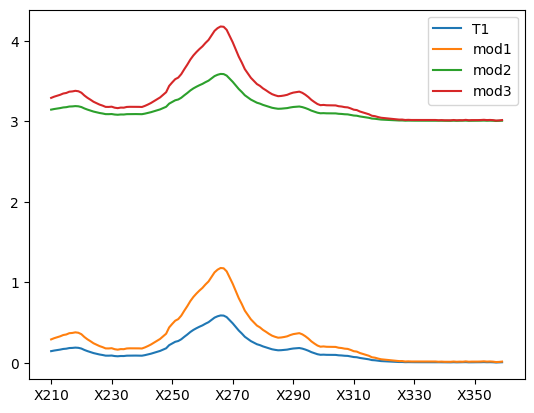

In [19]:
# To illustrate the corrections MSC makes, let's take 1 spectra as a baseline
# and modify it.
baseline = df.loc['T1']

mod1 = baseline * 2 # Multiplicative effect
mod2 = baseline + 3 # Additive effect
mod3 = baseline*2 + 3 # Both

mod1.name = 'mod1'
mod2.name = 'mod2'
mod3.name = 'mod3'

new_set = pd.concat([baseline, mod1, mod2, mod3], axis=1).T

# Let's plot these 4 curves to see what they look like
new_set.T.plot()

<Axes: >

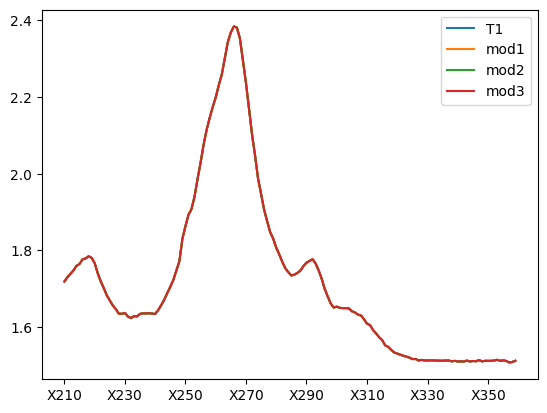

In [20]:
# Let's apply the MSC transformation - they are all coincident now!
pd.DataFrame(
    data=MSC().fit_transform(new_set),
    columns=new_set.columns,
    index=['T1', 'mod1', 'mod2', 'mod3']
).T.plot()

<Axes: >

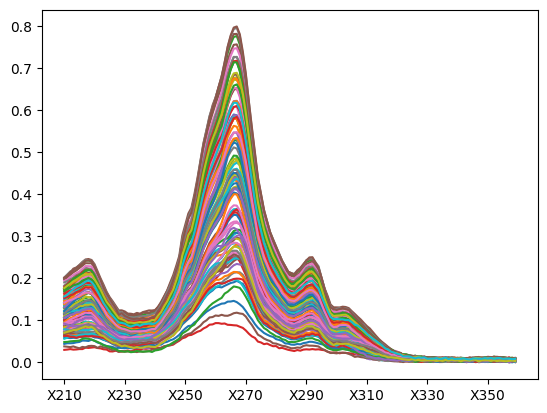

In [21]:
# Plot the entire dataframe
df.T.plot(y=df.index, legend=False)

<Axes: >

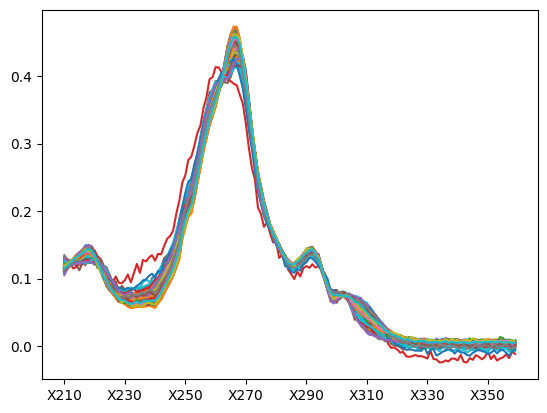

In [22]:
transformer = MSC()
_ = transformer.fit(df)
xformed = pd.DataFrame(
    data=transformer.transform(df),
    columns=df.columns
)

xformed.T.plot(y=xformed.index, legend=False)

## SNV and RNV

The standard normal variates (SNV) is a filter that is usually associated with spectral data as well.  It also corrects for both additive ➕ and multiplicative
✖ effects, and is generally preferred over MSC.  The "robust" (RNV) version simply uses the median and interquartile range in place of the mean and standard deviation the same way the RobustScaler does above.

---
> ❗ Read the documentation for SNV.
---

In [23]:
from pychemauth.preprocessing.filter import SNV
?SNV

<Axes: >

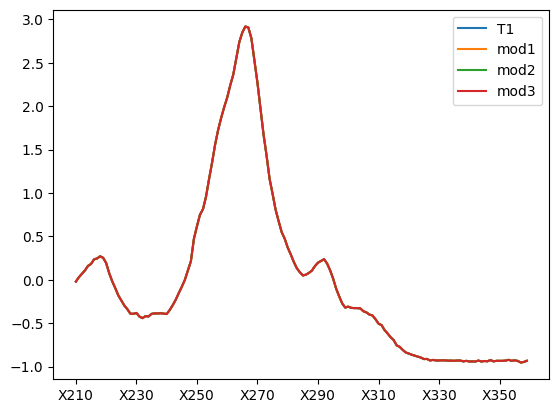

In [24]:
# Let's apply the SNV transformation - they are all coincident now, just like MSC.
pd.DataFrame(
    data=SNV().fit_transform(new_set),
    columns=new_set.columns,
    index=['T1', 'mod1', 'mod2', 'mod3']
).T.plot()

<Axes: >

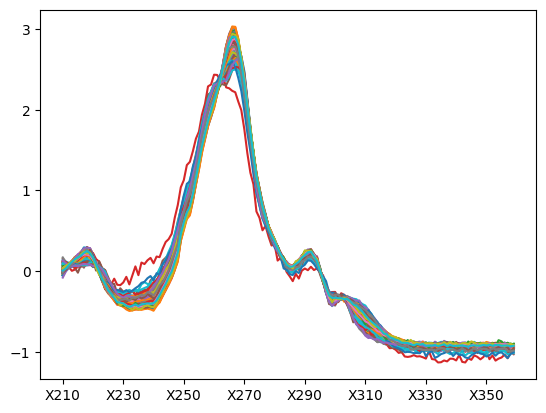

In [27]:
# The SNV variation
transformer = SNV(robust=False, detrend=False)
_ = transformer.fit(df)
xformed = pd.DataFrame(
    data=transformer.transform(df),
    columns=df.columns
)

xformed.T.plot(y=xformed.index, legend=False)

<Axes: >

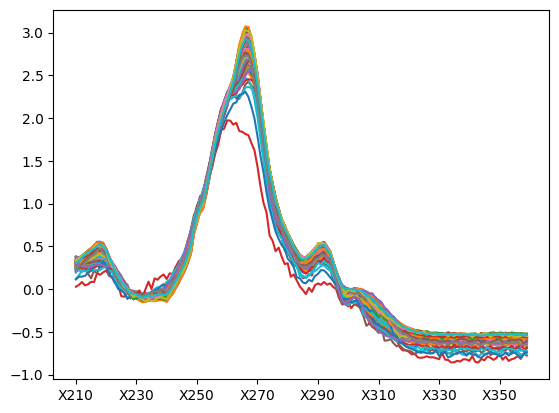

In [28]:
transformer = SNV(q=50, robust=True, detrend=False)
_ = transformer.fit(df)
xformed = pd.DataFrame(
    data=transformer.transform(df),
    columns=df.columns
)

xformed.T.plot(y=xformed.index, legend=False)

## Savitzky-Golay

<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/Lissage_sg3_anim.gif" height=300 align="right"/>

The [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is method of smoothing data without distorting the trend of the data.  This is accomplished via one-dimensional "convolutions" (the same as in convolutional neural networks) with polynomials.  Essentially, the value of a point is estimated by fitting a polynomial of a certain order to a local neighborhood of points ("window"), then using that polynomial to estimate the value.  The window is usually an odd number since the point being estimated is the center; e.g., a window of 5 uses 2 points to the left ⬅, 2 points to the right ➡, plus itself to perform this fitting.

The gif at the right illustrates the process and is from <a href="//commons.wikimedia.org/wiki/User:Cdang" title="User:Cdang">Cdang</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24312864">Link</a>

> From Wikipedia: Savitzky and Golay's paper is one of the most widely cited papers in the journal Analytical Chemistry and is classed by that journal as one of its "10 seminal papers" saying "it can be argued that the dawn of the computer-controlled analytical instrument can be traced to this article."


---
> ❗ Read the documentation for SavGol.
---

In [29]:
from pychemauth.preprocessing.filter import SavGol
?SavGol

Text(0.5, 1.0, 'Smoothed Data')

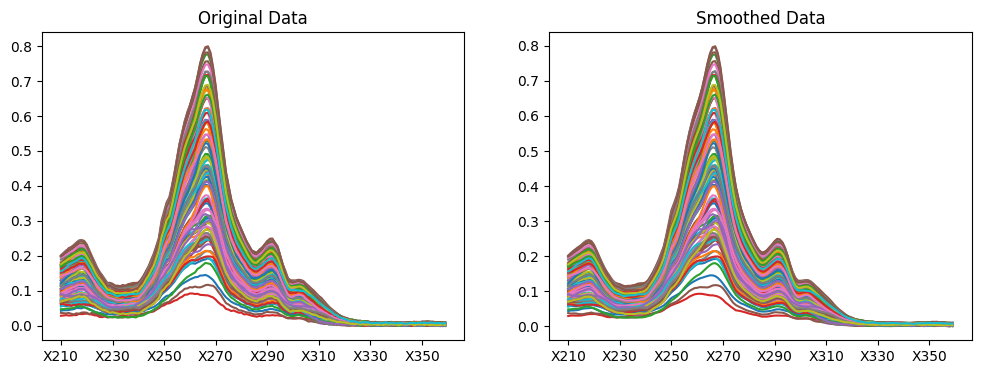

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Original data
df.T.plot(y=df.index, legend=False, ax=axes[0])
axes[0].set_title('Original Data')

# Smoothed data
xformed = pd.DataFrame(
    data=SavGol(window_length=5, polyorder=3).fit_transform(df),
    columns=df.columns
)
xformed.T.plot(y=xformed.index, legend=False, ax=axes[1])
axes[1].set_title('Smoothed Data')

⚠ However, using windows that are tool large can smooth the data too much, possibly erasing important trends.  It is important to select a reasonable window length and order of the polynomial.

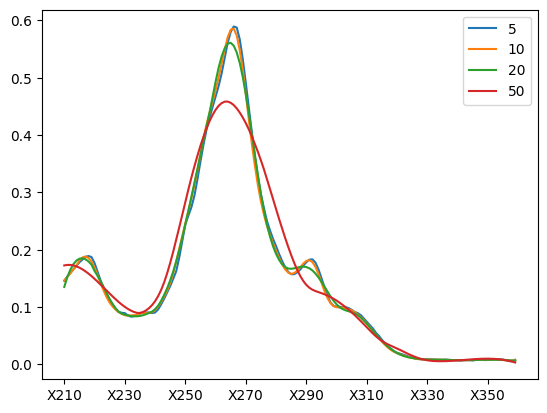

In [31]:
X = []
for wl in [5, 10, 20, 50]:
    X.append(SavGol(window_length=wl, polyorder=3).fit_transform(df.iloc[:1])[0].tolist())
smoothed = pd.DataFrame(data=np.array(X), columns=df.columns, index=[5, 10, 20, 50])

_ = smoothed.T.plot(y=smoothed.index, legend=True)

On its own SavGol does not correct for any baseline, it is just a way to smooth noisy data. However, because a polynomial is being used behind the scenes to do the fitting, we can use that to easily estimate the derivative(s) of the curve also!  Consider a second order polynomial ($ax^2$) where a multiplicative ($bx$) and additive ($c$) baseline have been added, so the measurand ($y$) is given by:

$$
y = a x^2 + b x + c
$$

The first derivative yields:

$$
\frac{{\rm d} y}{{\rm d} x} = 2ax + b
$$

So additive corrections ($c$) are removed with the first derivative.  The second derivative yields:

$$
\frac{{\rm d}^2 y}{{\rm d} x^2} = 2a
$$

Thus, multiplicative corrections are removed with the second and so on.  In this example, SavGol allows us to transform the data in a way that allows us to learn what $a$ is, given $x$ and $y$. The second derivative of the SavGol filter is commonly used in analytical chemistry to flatten baselines in spectroscopy.  Wikipedia has some illustrative [examples](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter#Applications).

In [67]:
# These modifications are different - previously, the multiplicative effects
# were constants that multiplied the value of the spectra at each point.
# Thus, the change was proportional to the value of the signal itself, whereas
# now, it is a function of the position along the spectra (e.g., energy value).

baseline = df.loc['T1']

x_ = np.arange(baseline.shape[0])
mod1_alt = baseline + 0.01*x_ # Multiplicative effect
mod2_alt = baseline + 3 # Additive effect
mod3_alt = baseline + 0.01*x_ + 3 # Both

mod1_alt.name = 'mod1_alt'
mod2_alt.name = 'mod2_alt'
mod3_alt.name = 'mod3_alt'

new_set_2 = pd.concat([baseline, mod1_alt, mod2_alt, mod3_alt], axis=1).T

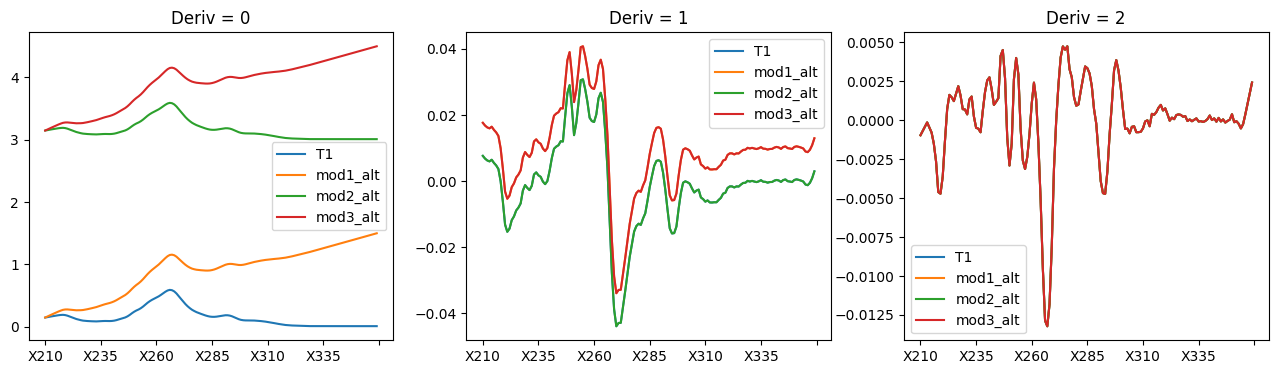

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

for deriv, ax in zip([0, 1, 2], axes):
    pd.DataFrame(
        data=SavGol(window_length=7, polyorder=3, deriv=deriv).fit_transform(new_set_2),
        columns=new_set.columns,
        index=['T1', 'mod1_alt', 'mod2_alt', 'mod3_alt']
    ).T.plot(ax=ax)
    ax.set_title(f'Deriv = {deriv}')

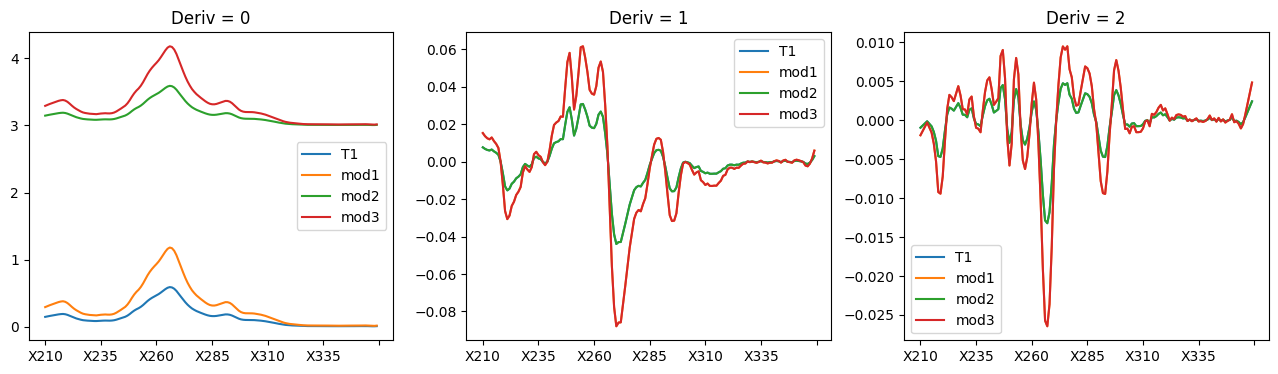

In [69]:
# Additive effects are removed, however, "multiplicative" effects that are not
# constant (in this case, they depend on the value of the spectra) are not
# removed by SavGol, unlike previous methods.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

for deriv, ax in zip([0, 1, 2], axes):
    pd.DataFrame(
        data=SavGol(window_length=7, polyorder=3, deriv=deriv).fit_transform(new_set),
        columns=new_set.columns,
        index=['T1', 'mod1', 'mod2', 'mod3']
    ).T.plot(ax=ax)
    ax.set_title(f'Deriv = {deriv}')

# Missing Values and Imputation

Another important part of data preprocessing / cleaning is how missing values are treated.  Missing values are a common problem in many disciplines and should be caught during EDA; however, in chemometric applications, we often encounter a related issue which is when a measurement is below ⏬ the limit of detection (LOD) of an instrument.  In this case, the value in the data table is essentially a nonsensical number output by the instrument.

There are a number of different practices that people use to handle this like recording a value of "0" or even a fixed number (like $\sqrt{2}$); however, any fixed value can bias a learning algorithm since it is a **pattern** that could be learned.

👉 Instead, we recommend you impute the value to a random number below the LOD.



## Limits of Detection (LOD)

---
> ❗ Read the documentation for LOD.
---

In [78]:
from pychemauth.preprocessing.missing import LOD
?LOD

In [71]:
# Let's create a dummy dataset to play with.
# Here, we have 4 measurements with 3 features each.
# Note that np.nan means a point is missing.
X = [
    [1.0, 2.0, np.nan],
    [2.0, 5.0, 1.0],
    [0.1, 3.5, 1.0],
    [0.5, 0.6, 1.5]
]

In [72]:
lod = LOD(
    lod=[0.75, 2.1, 0.5], # Assume the LOD for each feature is known.
    missing_values=np.nan, # Ignore these points since we assume they are missing.
    seed=42, # Seed so random numbers are generated the same way each time for reproducibility.
)

In [73]:
# Observe how this leaves the points above their lod alone, but changes those
# below to random numbers between [0, lod(i)] for each feature i.

# But what happened with the NaN?
lod.fit_transform(X)

array([[1.        , 1.80305563, 0.04708867],
       [2.        , 5.        , 1.        ],
       [0.58046704, 3.5       , 1.        ],
       [0.32915883, 1.46447286, 1.5       ]])

The LOD preprocessor is configured to fill in BOTH missing and values below LOD with randomly generated numbers.

1. This should only be applied for features which are greater than zero since a random number less than LOD will be generated.  For example, do NOT use this for stable isotope values (reported relative to artifact levels).

2. We may want to use another method to impute the missing values instead.  This is what the `ignore` parameter allows you to do.

In [83]:
lod = LOD(
    lod=[0.75, 2.1, 0.5],
    seed=42,
    ignore=np.nan # Now, let's ignore np.nan values since they are a placeholder for missing values.
)

lod.fit_transform(X)

array([[1.        , 1.80305563,        nan],
       [2.        , 5.        , 1.        ],
       [0.58046704, 3.5       , 1.        ],
       [0.32915883, 1.46447286, 1.5       ]])

## Basic Imputation

sklearn has a number of built-in [imputation tools](https://scikit-learn.org/stable/api/sklearn.impute.html) which are fully compatible with PyChemAuth.  The most common method is to simply impute missing values using a [measure of central tendency](https://en.wikipedia.org/wiki/Central_tendency).  

👉 This approach is fine for regression problems, but it does not take into account different classes in classification problems.  It might make more sense in those cases to separate the classes and impute each one separately, since the central tendency for each class might be (truly) different.

In [75]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit_transform(X)

array([[1.        , 2.        , 1.16666667],
       [2.        , 5.        , 1.        ],
       [0.1       , 3.5       , 1.        ],
       [0.5       , 0.6       , 1.5       ]])

In [76]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit_transform(X)

array([[1. , 2. , 1. ],
       [2. , 5. , 1. ],
       [0.1, 3.5, 1. ],
       [0.5, 0.6, 1.5]])

In [77]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit_transform(X)

array([[1. , 2. , 1. ],
       [2. , 5. , 1. ],
       [0.1, 3.5, 1. ],
       [0.5, 0.6, 1.5]])

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-10)
imputer.fit_transform(X)

array([[  1. ,   2. , -10. ],
       [  2. ,   5. ,   1. ],
       [  0.1,   3.5,   1. ],
       [  0.5,   0.6,   1.5]])

This can be combined with the LOD tools in a pipeline.  

1. Let's start by fixing the measurements that were made and turned out to be less than LOD.
2. Then, we will impute the missing values to the column (feature) mean.

👉 We generally advise this order of steps since measurements < LOD were measurements that were actually made, they are just potentially spurious.  These should be corrected first because this information (via central tendencies) is often used to impute the points that are missing.

In [84]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ("handle_lod", LOD(
            lod=[0.75, 2.1, 0.5],
            seed=42,
            ignore=np.nan # Now, let's ignore np.nan values since they are a placeholder for missing values.
        )),
        ("impute_missing", SimpleImputer(
            missing_values=np.nan,
            strategy='mean'
        )),
    ]
)

pipeline.fit_transform(X)

array([[1.        , 1.80305563, 1.16666667],
       [2.        , 5.        , 1.        ],
       [0.58046704, 3.5       , 1.        ],
       [0.32915883, 1.46447286, 1.5       ]])

More examples are available in the PyChemAuth API [documentation](https://pychemauth.readthedocs.io/en/latest/jupyter/api/imputing.html#Below-Limit-of-Detection-(LOD)).

## Predictive Imputers

The imputation methods discussed so far are fairly simple.  However, more complex schemes can be developed to, for example, fit a function that predicts column A values based on the others.  In that case, if a point in A is missing, we could fill in the missing value with a reasonable guess using the other features we have measured.  

There are 2 general approaches we could take:

1. 🙈 Unsupervised - here, we just use the feature matrix (no labels or $y$ values) and develop a method to fill in the gaps.

2. 👀 Supervised - here we can use the target or output value to help build a regression model to predict th missing data.

In the statistics and machine learning community, efforts are underway to provide some [standardized tools](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) for this.  The chemometrics community already has several well-known tools to do this, which we have implemented in PyChemAuth [missing module.](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#module-pychemauth.preprocessing.missing)

The general approach is iterative and involves the following steps:
1. make an initial guess at the missing data (perhaps using SimpleImputer),
2. build a model of the data,
3. use the model to predict the missing data.
4. Repeat steps 2-3 until the predictions converge or a maximum number of iterations have been reached.

An unsupervised approach involves using PCA to model the data, while a supervised approach involves using PLS as the model instead.  Both are illustrated in PyChemAuth [here](https://pychemauth.readthedocs.io/en/latest/jupyter/api/imputing.html).


# Class Balancing

We have already discussed some of the impacts that class imbalance has on models.  There are several methods to handling this issue:

1. Choose a better metric (instead of e.g., accuracy)
2. Weight data points by their inverse frequency (not possible for all models, but is for many)
3. Re-sampling (create synthetic data)

The last option is one of the easiest approaches.  The idea is simply to try to create realistic, but false, data that can be used to during training so the same number of points for each class are seen by the model.

A dedicated notebook illustrating and explaining common methods of achieving this is available in the PyChemAuth [documentation](https://pychemauth.readthedocs.io/en/latest/jupyter/api/imbalanced_classes.html).

## SMOTE

<img src="https://github.com/mahynski/pychemauth/blob/main/docs/_static/imblearn_generation.png?raw=true" height=400 align="right"/>

[Synthetic Minority Over-sampling TEchnique (SMOTE)](https://www.jair.org/index.php/jair/article/view/10302) is a common method for generating synthetic data by interpolating between neighboring points of the same class to create new fictitious data points. The [algorithm](https://imbalanced-learn.org/stable/over_sampling.html#sample-generation) is as follows (illustrated at the right):

1. Select a random point,
2. Select a random neighbor (using K-nearest-neighbors algorithm),
3. Place a new point randomly along a line between the 2 points.

This is a method of [oversampling](https://imbalanced-learn.org/stable/over_sampling.html) minority class(es).

SMOTE is simple and easy to implement, however, one basic problem with it is that we might choose outlying or extreme points in step 2, which would lead to the synthetic data getting "stretched" in a suboptimal "direction".  There are [several variants](https://imbalanced-learn.org/stable/over_sampling.html#smote-variants) of SMOTE intended to combat this, but they all fundamentally try to identify the "border" of a class then generate points that move "inward" toward the class center. We will use a different approach in the subsequent sections; for now, let's just see what SMOTE looks like.


In [85]:
from imblearn.over_sampling import SMOTE
from pychemauth.datasets import load_stamp2010

---
> ❗ Read the documentation on SMOTE.
---

In [86]:
?SMOTE

In [87]:
# Use some imbalanced data available in PyChemAuth
data_bunch = load_stamp2010(return_X_y=False, as_frame=True)

In [88]:
data_bunch.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'frame', 'DESCR'])

In [89]:
data_bunch['data']

,"2,4' DDD","2,4' DDE","4,4' DDD and 2,4' DDT","4,4' DDE","4,4' DDT",HCB,PCB 105,PCB 107,PCB 110,PCB 138,...,PCBs 28 and 31,a-HCH,cis-chlordane,cis-nonachlor,g-HCH,mirex,oxychlordane,total mercury,trans-chlordane,trans-nonachlor
0,0.046087,0.266000,0.127432,412.0,0.037299,35.3,2.82,2.040000,0.066760,42.00,...,3.99,1.130,0.007855,1.220,0.276,2.840,10.20,0.1409,0.054008,0.206
1,0.050111,0.255000,0.101151,194.0,0.041345,32.3,4.52,0.778000,0.056223,15.80,...,1.92,0.909,0.052286,0.400,0.290,1.450,5.26,0.1787,0.022724,0.168
2,0.044125,0.284000,1.576000,173.0,0.087000,27.0,3.17,0.629000,0.552000,17.60,...,2.57,0.947,0.458000,8.820,0.227,1.970,7.51,0.1596,0.435000,3.110
3,0.066260,0.264000,1.190000,197.0,0.009136,31.4,2.93,0.541000,0.044733,10.60,...,2.13,1.160,0.016975,0.503,0.306,1.660,5.94,0.1140,0.046001,0.177
4,0.046355,0.177000,0.066805,266.0,0.007308,24.9,5.03,1.250000,0.008425,7.90,...,2.26,1.330,0.018454,1.340,0.453,2.760,7.41,0.1984,0.054451,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.901000,0.124000,1.680000,156.0,0.003065,65.8,4.09,0.027420,0.042023,8.88,...,3.42,2.520,0.355000,0.554,0.675,1.170,8.46,0.0967,0.838000,0.825
457,1.640000,0.042752,3.130000,95.0,0.021095,38.6,2.42,0.153000,0.019226,5.19,...,1.72,2.270,1.180000,1.310,0.955,0.272,6.38,0.1142,1.450000,1.410
458,0.883000,0.472000,1.730000,70.6,0.029418,53.2,2.33,0.028093,0.007207,6.29,...,2.41,1.420,0.489000,0.627,0.475,0.221,7.08,0.0441,0.790000,1.100
459,1.410000,0.736000,2.204000,99.7,0.024748,61.0,2.91,0.034621,0.026401,7.55,...,2.79,2.660,0.394000,0.727,0.646,0.990,7.63,0.0178,0.797000,0.988


In [90]:
data_bunch['DESCR']

"Dataset reported in Schuur, Stacy S., Ragland, Jared M., Mahynski, Nathan A. (2021), Data Supporting 'Seabird Tissue Archival and Monitoring Project (STAMP) Data from 1999-2010', National Institute of Standards and Technology, https://doi.org/10.18434/mds2-2431 . See this publication for a full description."

<Axes: >

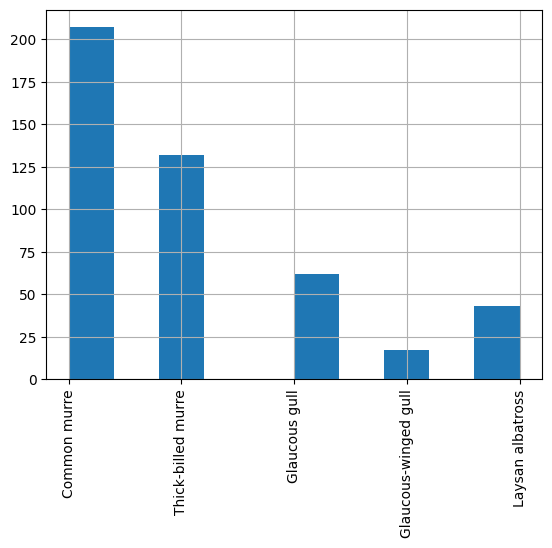

In [91]:
# Common murre is the majority class
data_bunch['target']['COMMON_NAME'].hist(xrot=90)

In [92]:
resampler = SMOTE(random_state=42)

X_resampled, y_resampled = resampler.fit_resample(
    X=data_bunch['data'].values,
    y=data_bunch['target']['COMMON_NAME'].values
)

In [93]:
X_resampled.shape, y_resampled.shape, data_bunch['data'].shape

((1035, 49), (1035,), (461, 49))

👀 Let's take a look at what SMOTE resampling has done for us.

Text(0.5, 1.0, 'Complete Resampled Dataset')

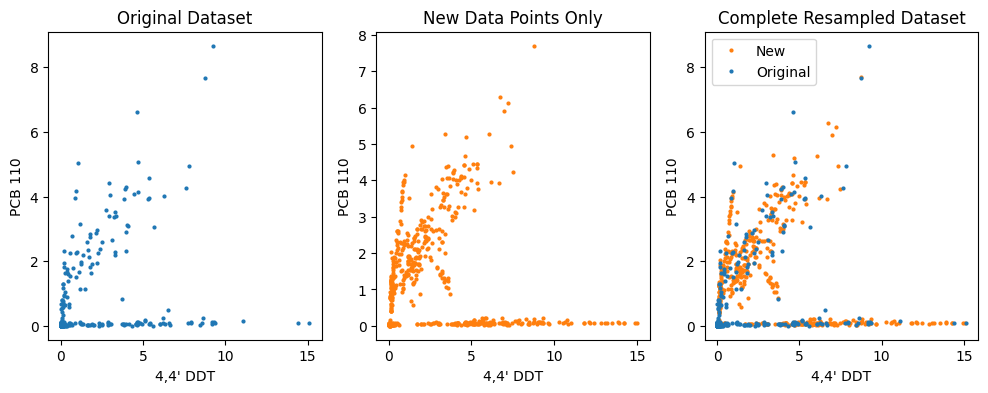

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for ax in axes:
    ax.set_xlabel(data_bunch['feature_names'][4])
    ax.set_ylabel(data_bunch['feature_names'][8])

axes[0].plot(data_bunch['data'].iloc[:,4], data_bunch['data'].iloc[:,8], 'o', ms=2)
axes[0].set_title('Original Dataset')

resampled_ = set([tuple(x) for x in np.vstack((X_resampled[:,4], X_resampled[:,8])).T])
original_ = set([tuple(x) for x in np.vstack((data_bunch['data'].iloc[:,4].values, data_bunch['data'].iloc[:,8].values)).T])
new_points = np.array(list(resampled_ - original_))
axes[1].plot(new_points[:,0], new_points[:,1], 'o', ms=2, color='C1')
axes[1].set_title('New Data Points Only')

axes[2].plot(new_points[:,0], new_points[:,1], 'o', ms=2, label='New', color='C1')
axes[2].plot(data_bunch['data'].iloc[:,4], data_bunch['data'].iloc[:,8], 'o', ms=2, label='Original', color='C0')
axes[2].legend(loc='best')
axes[2].set_title('Complete Resampled Dataset')

<Axes: >

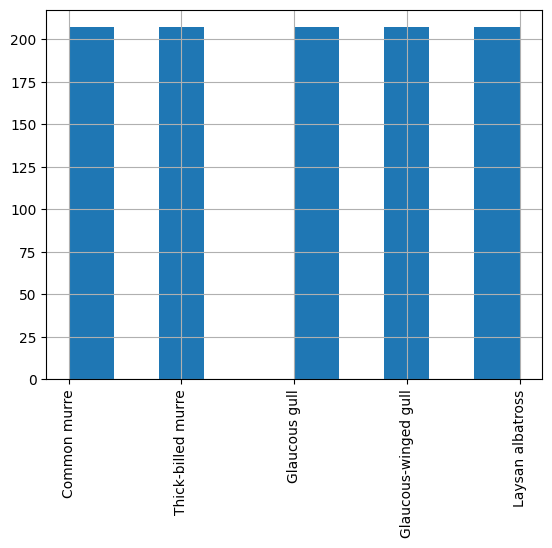

In [95]:
pd.Series(data=y_resampled).hist(xrot=90)

## Edited Nearest Neighbors (ENN)

The opposite of overampling is [undersampling](https://imbalanced-learn.org/stable/under_sampling.html) in which we remove data from all class(es) except the minority class.  This is not usually as popular as oversampling since it involves throwing away real data.  Nonetheless, a combination of over- and undersampling has emperically been found to usually be the best way of addressing class imbalance.

[Edited nearest neighbors](https://imbalanced-learn.org/stable/under_sampling.html#edited-nearest-neighbours) (ENN) is one popular algorithm for undersampling and works sort of like the opposite of SMOTE.  It uses K-nearest neighbors to identify the neighbors of samples, then removes samples if any or most of their neighbours are from a different class.  The algorithm is as follows:

1. Train a KNN model using the entire dataset,
2. For each sample of a given target class, find the closest K neighbors,
3. If a certain number of neighbors belong to a different class, then remove the point.

In step 3, the "certain number of neighbors" can be tuned - for example, we could require that ALL neighbors be the same class, or just most of them.  This is a tunable hyperperparameter.

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours as ENN

---
> ❗ Read the documentation on ENN.
---

In [ ]:
?ENN

In [ ]:
resampler = ENN(
    sampling_strategy='not minority', # Resample all classes except minority class
    kind_sel='all'
)

In [ ]:
# So we will undersample all classes except Glaucous-winged gull
data_bunch['target']['COMMON_NAME'].value_counts()

Common murre            207
Thick-billed murre      132
Glaucous gull            62
Laysan albatross         43
Glaucous-winged gull     17
Name: COMMON_NAME, dtype: int64

In [ ]:
X_resampled, y_resampled = resampler.fit_resample(
    X=data_bunch['data'].values,
    y=data_bunch['target']['COMMON_NAME'].values
)

In [ ]:
X_resampled.shape, y_resampled.shape, data_bunch['data'].shape

((166, 49), (166,), (461, 49))

<Axes: >

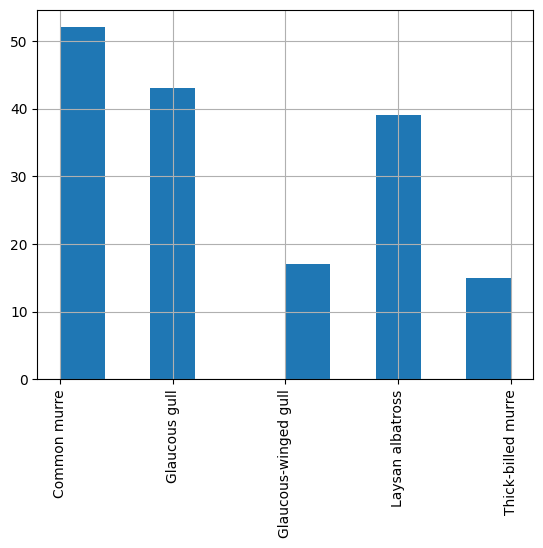

In [ ]:
# Note that Glaucous-winged gull is not (necessarily) the minority class anymore!
pd.Series(data=y_resampled).hist(xrot=90)

Text(0.5, 1.0, 'Resampled Dataset')

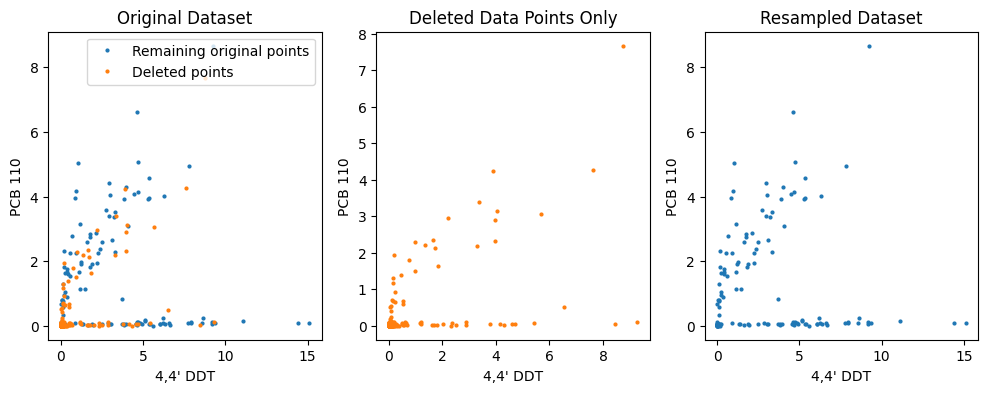

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for ax in axes:
    ax.set_xlabel(data_bunch['feature_names'][4])
    ax.set_ylabel(data_bunch['feature_names'][8])

resampled_ = set([tuple(x) for x in np.vstack((X_resampled[:,4], X_resampled[:,8])).T])
original_ = set([tuple(x) for x in np.vstack((data_bunch['data'].iloc[:,4].values, data_bunch['data'].iloc[:,8].values)).T])

deleted_points = np.array(list(original_ - resampled_))
resampled_points = np.array(list(resampled_))

axes[0].plot(resampled_points[:,0], resampled_points[:,1], 'o', ms=2, label='Remaining original points')
axes[0].plot(deleted_points[:,0], deleted_points[:,1], 'o', ms=2, label='Deleted points')
axes[0].legend(loc='best')
axes[0].set_title('Original Dataset')

axes[1].plot(deleted_points[:,0], deleted_points[:,1], 'o', ms=2, color='C1')
axes[1].set_title('Deleted Data Points Only')

axes[2].plot(resampled_points[:,0], resampled_points[:,1], 'o', ms=2)
axes[2].set_title('Resampled Dataset')

## SMOTEENN

The issue with SMOTE interpolating toward outliers can be solved by combining it with ENN.  In general, ENN should be applied after SMOTE so we can make the most use of the data we have.  As previously shown with ENN, the result will not be a perfectly balanced dataset, but it will be much better than what we originally started with.  This [combination](https://imbalanced-learn.org/stable/combine.html) of over- and undersampling is generally considered an optimal approach.

In [ ]:
from imblearn.combine import SMOTEENN

---
> ❗ Read the documentation on SMOTEENN.
---

In [ ]:
?SMOTEENN

In [ ]:
resampler = SMOTEENN(
    smote=SMOTE(random_state=42, sampling_strategy='not majority'),
    enn=ENN(sampling_strategy='not minority', kind_sel='all')
)

In [ ]:
X_resampled, y_resampled = resampler.fit_resample(
    X=data_bunch['data'].values,
    y=data_bunch['target']['COMMON_NAME'].values
)

In [ ]:
X_resampled.shape, y_resampled.shape, data_bunch['data'].shape

((852, 49), (852,), (461, 49))

<Axes: >

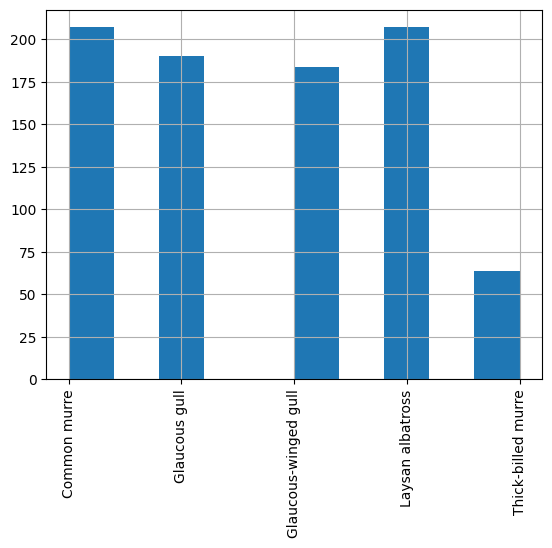

In [ ]:
pd.Series(data=y_resampled).hist(xrot=90)

Text(0.5, 1.0, 'Resampled Dataset')

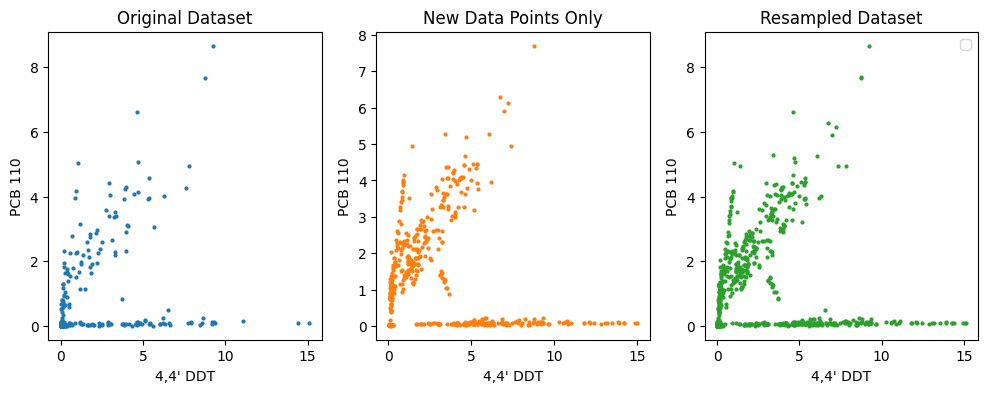

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for ax in axes:
    ax.set_xlabel(data_bunch['feature_names'][4])
    ax.set_ylabel(data_bunch['feature_names'][8])

axes[0].plot(data_bunch['data'].iloc[:,4], data_bunch['data'].iloc[:,8], 'o', ms=2)
axes[0].set_title('Original Dataset')

resampled_ = set([tuple(x) for x in np.vstack((X_resampled[:,4], X_resampled[:,8])).T])
original_ = set([tuple(x) for x in np.vstack((data_bunch['data'].iloc[:,4].values, data_bunch['data'].iloc[:,8].values)).T])
new_points = np.array(list(resampled_ - original_))
axes[1].plot(new_points[:,0], new_points[:,1], 'o', ms=2, color='C1')
axes[1].set_title('New Data Points Only')

resampled_points = np.array(list(resampled_))
axes[2].plot(resampled_points[:,0], resampled_points[:,1], 'o', ms=2, color='C2')
axes[2].legend(loc='best')
axes[2].set_title('Resampled Dataset')

## ScaledSMOTEENN

There is one more pernicious feature of SMOTE(ENN) that we should be aware of.  Since these methods rely on KNN models, they are computing a distance between points, $a$ and $b$, using the feature columns, e.g.,

$$
d_{a,b} = \sqrt{({\rm Col}_1(a) - {\rm Col}_1(b))^2 + ({\rm Col}_2(a) - {\rm Col}_2(b))^2 + \dots}
$$

If the columns (features) are measured in very different units / scales, then this distance will be dominated by the columns with the largest numbers. Therefore, the closest $k$ points selected for interpolation with SMOTE, or neighborhood comparison with ENN, will be biased based on which points have the most similar large-valued columns.

For example, assume we have a 3 points with 4 features:

| | A | B | C | D |
| --- | --- | --- | --- | --- |
| 1 | 1 | 10 | 100 | 1000 |
| 2 | 2 | 20 | 200 | 2000 |
| 3 | 3 | 30 | 300 | 3000 |

In [ ]:
data = np.array([
    [1, 10, 100, 1000],
    [2, 20, 200, 2000],
    [3, 30, 300, 3000]
])

def dist(i, j):
    return np.sqrt(np.sum((data[i] - data[j])**2))

for i in range(3):
    for j in range(i+1, 3):
        print(i+1, j+1, dist(i, j))

1 2 1005.037810234023
1 3 2010.075620468046
2 3 1005.037810234023


⚠ Clearly, the distance between points is basically just the distance between the values of column D.  So the $k$ nearest neighbors of a point are just those with the $k$ most similar values of D.  This is usually NOT what we want to happen, especially since this entirely depends on the units 📏 of measurement! Let's look at the sample data we are working with:





In [ ]:
data_bunch['data']

,"2,4' DDD","2,4' DDE","4,4' DDD and 2,4' DDT","4,4' DDE","4,4' DDT",HCB,PCB 105,PCB 107,PCB 110,PCB 138,...,PCBs 28 and 31,a-HCH,cis-chlordane,cis-nonachlor,g-HCH,mirex,oxychlordane,total mercury,trans-chlordane,trans-nonachlor
0,0.046087,0.266000,0.127432,412.0,0.037299,35.3,2.82,2.040000,0.066760,42.00,...,3.99,1.130,0.007855,1.220,0.276,2.840,10.20,0.1409,0.054008,0.206
1,0.050111,0.255000,0.101151,194.0,0.041345,32.3,4.52,0.778000,0.056223,15.80,...,1.92,0.909,0.052286,0.400,0.290,1.450,5.26,0.1787,0.022724,0.168
2,0.044125,0.284000,1.576000,173.0,0.087000,27.0,3.17,0.629000,0.552000,17.60,...,2.57,0.947,0.458000,8.820,0.227,1.970,7.51,0.1596,0.435000,3.110
3,0.066260,0.264000,1.190000,197.0,0.009136,31.4,2.93,0.541000,0.044733,10.60,...,2.13,1.160,0.016975,0.503,0.306,1.660,5.94,0.1140,0.046001,0.177
4,0.046355,0.177000,0.066805,266.0,0.007308,24.9,5.03,1.250000,0.008425,7.90,...,2.26,1.330,0.018454,1.340,0.453,2.760,7.41,0.1984,0.054451,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.901000,0.124000,1.680000,156.0,0.003065,65.8,4.09,0.027420,0.042023,8.88,...,3.42,2.520,0.355000,0.554,0.675,1.170,8.46,0.0967,0.838000,0.825
457,1.640000,0.042752,3.130000,95.0,0.021095,38.6,2.42,0.153000,0.019226,5.19,...,1.72,2.270,1.180000,1.310,0.955,0.272,6.38,0.1142,1.450000,1.410
458,0.883000,0.472000,1.730000,70.6,0.029418,53.2,2.33,0.028093,0.007207,6.29,...,2.41,1.420,0.489000,0.627,0.475,0.221,7.08,0.0441,0.790000,1.100
459,1.410000,0.736000,2.204000,99.7,0.024748,61.0,2.91,0.034621,0.026401,7.55,...,2.79,2.660,0.394000,0.727,0.646,0.990,7.63,0.0178,0.797000,0.988


😨 It looks like SMOTE(ENN) will just select neighbors with the most similar 4,4' DDE values!

🙋 But we can solve this by simply scaling the data!  This is what `ScaledSMOTEENN` does automatically for you.

1. Scale data,
2. Perform SMOTEENN in the dimensionless space,
3. Then de-scale the results to put it back in original units

Step 3 ensures the output of this pre-processor does not interfere with other steps in your pipeline.

In [ ]:
from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN

---
> ❗ Read the documentation for ScaledSMOTEENN.
---

In [ ]:
?ScaledSMOTEENN

In [ ]:
resampler = ScaledSMOTEENN(
    sampling_strategy_smote='not majority',
    sampling_strategy_enn='not minority',
    kind_sel_enn='all',
    random_state=42,
    scaler=RobustScaler() # Can use any valid scaler
)

In [ ]:
X_resampled, y_resampled = resampler.fit_resample(
    X=data_bunch['data'].values,
    y=data_bunch['target']['COMMON_NAME'].values
)

In [ ]:
X_resampled.shape, y_resampled.shape, data_bunch['data'].shape

((940, 49), (940,), (461, 49))

<Axes: >

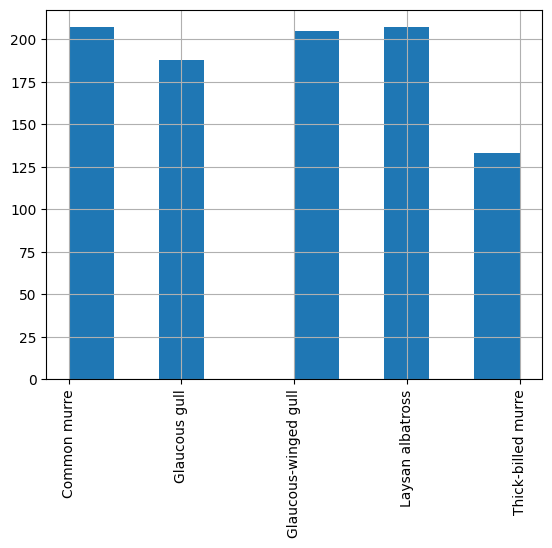

In [ ]:
pd.Series(data=y_resampled).hist(xrot=90)

Note how the the thick-billed murre (TBM) is much more evenly sampled now, compared to the other classes.  Apparently, scaling strongly influences the ENN stage; without scaling, many TBM points seemed to be surrounded by non-TBM points so ENN removed them more aggressively; with scaling, they seemed to be a bit more "independent" of the rest of the dataset.  In fact, this is most likely coming from the fact that TBM is chemometrically very similar to the common murre class (see [here](https://pychemauth.readthedocs.io/en/latest/jupyter/applications/2023_stamp.html#id2) for analysis) so it is likely the confusion / overlap between the two that is causing this to happen.

## Imblearn Pipelines

<img src="https://pychemauth.readthedocs.io/en/latest/_images/pipeline.png" height=357 align="right"/>

Re-sampling techniques which create "fake" data are helpful during training (when a model is being fitted), but what happens when we go to apply this model to unseen data?  For example, during k-fold CV the model is being trained on certain data folds (which should be balanced), but what happens on the test fold? 🤔

In fact, resamping should only be applied during training 🏃.  If it is applied during testing, we would create a bunch of "fake" data and report the accuracy based on all the real + fake data.  How would we interpret that?  We really only want to know how the model performs on the "real" data, so during testing we should not resample.  Unfortunately, sklearn's [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) 🔩 doesn't know how to handle that; in fact, it doesn't know how to handle resampling at all (it only focuses on `fit`,`transform`, and `predict` methods of its members).

Thankfully, a drop-in replacement 👇 from [imblearn](https://imbalanced-learn.org/stable/index.html) provides a [pipeline](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html) that can be used instead and handles these problems automatically.  You can see in the graphic at the right that the resampling is only performed during the training part of the pipeline.

❗ In most cases, we use imblearn's pipeline instead of sklearn's simply because of this.  PyChemAuth's documentation discusses this at greater length [here](https://pychemauth.readthedocs.io/en/latest/jupyter/api/pipelines.html#Imbalanced-learn-Pipelines).



In [ ]:
from imblearn.pipeline import Pipeline
from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN

In [ ]:
pipeline = Pipeline(
    steps=[
        ("handle_lod", LOD(
            lod=[0.001]*len(data_bunch['feature_names']), # A fictitious LOD for this example
            missing_values=np.nan,
            seed=42,
            ignore=np.nan
        )),
        ("impute_missing", SimpleImputer(
            missing_values=np.nan,
            strategy='mean'
        )),
        ("class_balancer", ScaledSMOTEENN(
            random_state=42
        )),
        ("autoscaler", CorrectedScaler(
            with_mean=True,
            with_std=True,
            pareto=False
        ))
    ]
)

# Feature Selection

Feature selection 👈 refers to the process of selecting a subset of features initially provided, usually with the goal of training a model with better generalized performance.  

[Feature "extraction"](https://scikit-learn.org/stable/modules/feature_extraction.html) 🤏 refers to the creation of new features using the raw data; for example, PCA produces principal components by linearly combining the input features. This term is typically not applied to cases of tabular data, though, and is instead more commonly used to refer to the extraction of numerical properties from texts or images.  

> This is "featurization" process is not necessary with deep learning models which are designed to automatically extract / create meaningful data representations *in situ*.  This is one perceived advantage, or at least convenience, of deep learning methods over more conventional machine learning approaches.

Feature selection is a common procedure in chemometric applications and detailed examples are provided in PyChemAuth's [documentation](https://pychemauth.readthedocs.io/en/latest/jupyter/api/feature_selection.html).  PyChemAuth's [feature_selection submodule](https://pychemauth.readthedocs.io/en/latest/pychemauth.preprocessing.html#module-pychemauth.preprocessing.feature_selection) contains numerous useful tools for this process.


